# Load dependencies

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [41]:
device = torch.device('cuda')

In [42]:
#### from https://github.com/gngdb/pytorch-pca/tree/main ####
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class TorchPCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    #@torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

# Load data

In [43]:
X_A = pd.read_csv('X_A.csv',index_col=0)
X_B = pd.read_csv('X_B.csv',index_col=0)
Y_A = pd.read_csv('Y_A.csv',index_col=0)
lean_control_chips = pd.read_csv('chip_lean_controls_indices.csv',index_col=0)
fatty_control_chips = pd.read_csv('chip_fatty_controls_indices.csv',index_col=0)

In [44]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [45]:
# X_B.loc[control_chips.index.values,:]

In [46]:
# scaler = StandardScaler()
# X_A2 = scaler.fit_transform(X_A)
# X_B2 = scaler.fit_transform(X_B)
# # initialize a PCA object with the largest value of n_components you can
# pca = PCA()
# # fit your PCA object to your data
# pca.fit(X_B2)
# # transform your data into PCA space
# Z_B = pca.transform(X_B2)
# # get total variance of X_A
# varA = np.var(X_A2,axis=0).sum()
# print(varA)
# loadings = pca.components_
# print(loadings.shape)
# Z_A_B = np.dot(X_A2,loadings.T)
# varAB = np.var(Z_A_B,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

In [47]:
# get total variance of X_A
varA = np.var(X_A,axis=0).sum()
print(varA)

1864.2939856979604


# Get PCA loadings

In [48]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X_B)
# transform your data into PCA space
Z_B = pca.transform(X_B)

Text(0.5, 1.0, 'in-vitro model PC space')

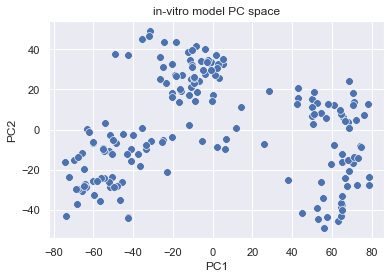

In [49]:
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# pca_data = pd.concat([pca_data,pd.DataFrame(data={'PC1':Z_A_B[:,0], 'PC2':Z_A_B[:,1]})])
# pca_data['dataset'] = ['in-vitro model' for i in range(Z_B.shape[0])] + ['humans' for i in range(Z_A_B.shape[0])]
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2', s =60 , palette= 'icefire')
plt.title('in-vitro model PC space')

In [50]:
loadings = pca.components_
print(loadings.shape)

(179, 14322)


In [51]:
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

The explained variance of the human data in the PC-space of liver chip is 33.19 %


In [52]:
pcs_to_keep = ["PC11","PC12","PC26","PC34","PC52","PC71","PC84","PC119","PC129","PC131","PC133","PC141","PC155","PC160"]

# Initialize perturbation as a small random dX

In [55]:
XB_lean = X_B.loc[lean_control_chips.index.values,:]
XB_fatty = X_B.loc[fatty_control_chips.index.values,:]
dX_lean = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,XB_lean.shape[1]))
dX_lean = torch.tensor(dX_lean).float().to(device)
dX_fatty = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,XB_fatty.shape[1]))
dX_fatty = torch.tensor(dX_fatty).float().to(device)
Input_fatty = torch.nn.Parameter(dX_fatty, requires_grad = True)
Input_fatty.retain_grad()
Input_lean = torch.nn.Parameter(dX_lean, requires_grad = True)
Input_lean.retain_grad()
optimizer = torch.optim.Adam([Input_lean,Input_fatty],lr= 0.1,weight_decay=0)
XB_lean = torch.tensor(XB_lean.values).float().to(device)
XB_lean = torch.mean(XB_lean,0,keepdim = True)
XB_fatty = torch.tensor(XB_fatty.values).float().to(device)
XB_fatty = torch.mean(XB_fatty,0,keepdim = True)
XB = torch.tensor(X_B.values).float().to(device)
XA = torch.tensor(X_A.values).float().to(device)

In [56]:
print(XB_fatty.shape)
print(XB_lean.shape)

torch.Size([1, 14322])
torch.Size([1, 14322])


Sample 0 Iteration=0, loss=-0.3254, explained_variance=33.64%
Sample 0 Iteration=200, loss=-0.4718, explained_variance=47.45%
Sample 0 Iteration=400, loss=-0.4711, explained_variance=47.48%
Sample 0 Iteration=600, loss=-0.4719, explained_variance=47.48%
Sample 0 Iteration=800, loss=-0.4708, explained_variance=47.45%
Sample 0 Iteration=999, loss=-0.4713, explained_variance=47.48%


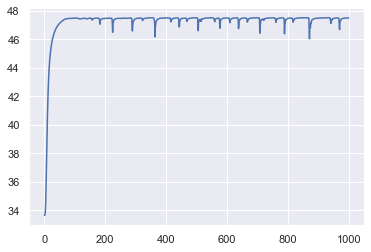

In [57]:
df_lean = pd.DataFrame({})
df_fatty = pd.DataFrame({})
# for j in range(XB_lean.shape[0]):
#     dX_lean = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,XB_lean.shape[1]))
#     dX_lean = torch.tensor(dX_lean).float().to(device)
#     dX_fatty = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,XB_fatty.shape[1]))
#     dX_fatty = torch.tensor(dX_fatty).float().to(device)
#     Input_fatty = torch.nn.Parameter(dX_fatty, requires_grad = True)
#     Input_fatty.retain_grad()
#     Input_lean = torch.nn.Parameter(dX_lean, requires_grad = True)
#     Input_lean.retain_grad()
#     optimizer = torch.optim.Adam([Input_lean,Input_fatty],lr= 0.1,weight_decay=0)
loss_all = []
exp_var_all = []
iters = 1000
torch.autograd.set_detect_anomaly(True)
j=0
for i in range(iters):
    optimizer.zero_grad()
    Xstar_lean = XB_lean + Input_lean
    Xstar_fatty = XB_fatty + Input_fatty
    X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
    #pca_new = TorchPCA(n_components=X.shape[0]).to(device).fit(X)
    #P = pca_new.components_
    U,S,V = torch.svd(X)
    #Z_A_B = torch.matmul(XA,P.T)
    Z_A_B = torch.matmul(XA,V)
    varAB = torch.var(Z_A_B,axis=0).sum()

    loss = - varAB/varA
    loss = loss + 1e-6 * torch.sum(torch.abs(Input_lean)) + 1e-6 * torch.sum(torch.abs(Input_fatty))
    loss.backward()
    optimizer.step()

    exp_var = 100 * varAB/varA
    exp_var = exp_var.item()
    loss_all.append(loss.item())
    exp_var_all.append(exp_var)
    if i % 200 == 0 :
        outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
        outString += ', loss={:.4f}'.format(loss.item())
        outString += ', explained_variance={:.2f}%'.format(exp_var)
        print(outString)
outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
outString += ', loss={:.4f}'.format(loss.item())
outString += ', explained_variance={:.2f}%'.format(exp_var)
print(outString)
lean_dx = pd.DataFrame(Input_lean.detach().cpu().numpy())
lean_dx.columns = X_B.columns.values
df_lean = df_lean.append(lean_dx)
fatty_dx = pd.DataFrame(Input_fatty.detach().cpu().numpy())
fatty_dx.columns = X_B.columns.values
df_fatty = df_fatty.append(fatty_dx)
plt.plot(range(iters),exp_var_all)

In [58]:
df_fatty.index = [i for i in range(XB_fatty.shape[0])]
df_lean.index = [i for i in range(XB_lean.shape[0])]

In [59]:
df_lean

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,DCAF15,CASP8AP2,NIPA1,ELP5,MIR23AHG,DDX51,YBX2,ISLR,C1R,PRKACA
0,-0.381633,0.018483,-0.465068,-0.085109,-0.087682,-0.294877,-0.032816,-0.391132,0.142185,-0.349597,...,0.079477,0.098603,-0.001844,0.014152,-0.072709,0.221642,-0.048503,0.412134,-0.115655,0.278886


In [60]:
df_fatty

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,DCAF15,CASP8AP2,NIPA1,ELP5,MIR23AHG,DDX51,YBX2,ISLR,C1R,PRKACA
0,-0.030539,0.035459,0.040969,0.049593,-0.015294,0.046786,0.047117,0.043373,-0.029846,0.028103,...,-0.037396,-0.010566,0.054903,-0.032141,-0.039749,0.013113,-0.067378,-0.043061,0.047148,-0.03166


In [20]:
df_lean.to_csv('dx_lean.csv')
df_fatty.to_csv('dx_fatty.csv')

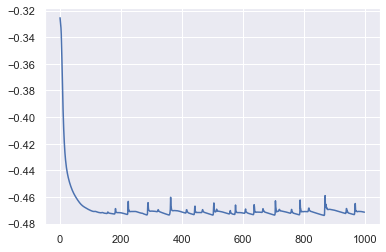

In [61]:
plt.plot(range(iters),loss_all)

In [62]:
# plt.plot(range(iters),exp_var_all)

(array([3.78012971e-04, 5.67019457e-04, 9.45032428e-04, 3.59112554e-03,
        9.07231131e-03, 2.36258107e-02, 6.80423348e-02, 2.33045034e-01,
        8.24068344e-01, 9.86424928e-01, 3.78013032e-01, 1.07166677e-01,
        4.00693814e-02, 1.53095253e-02, 7.74926591e-03, 4.15814268e-03,
        3.02410572e-03, 7.56025942e-04, 1.89006486e-04, 7.56025942e-04]),
 array([-3.533833  , -3.1644137 , -2.7949944 , -2.425575  , -2.056156  ,
        -1.6867366 , -1.3173172 , -0.9478979 , -0.57847863, -0.20905933,
         0.16035998,  0.52977926,  0.8991986 ,  1.2686179 ,  1.6380372 ,
         2.0074565 ,  2.3768759 ,  2.746295  ,  3.1157143 ,  3.4851336 ,
         3.854553  ], dtype=float32),
 <BarContainer object of 20 artists>)

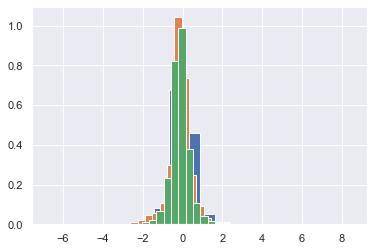

In [63]:
plt.hist(XB.detach().cpu().numpy().flatten(),20,density=True)
plt.hist(Xstar_fatty.detach().cpu().numpy().flatten(),20,density=True)
plt.hist(Xstar_lean.detach().cpu().numpy().flatten(),20,density=True)

(array([2.50052444e-04, 0.00000000e+00, 5.00104889e-04, 2.25047296e-03,
        7.75162578e-03, 3.67577172e-02, 1.82288251e-01, 8.73183323e-01,
        1.70835867e+00, 5.95124945e-01, 1.16274412e-01, 3.60075597e-02,
        1.40029369e-02, 6.00126123e-03, 1.25026222e-03, 5.00104889e-04,
        5.00104889e-04, 0.00000000e+00, 0.00000000e+00, 2.50052444e-04]),
 array([-2.3655303 , -2.0862982 , -1.8070663 , -1.5278343 , -1.2486024 ,
        -0.96937037, -0.6901384 , -0.4109064 , -0.13167444,  0.14755754,
         0.42678952,  0.7060215 ,  0.98525345,  1.2644855 ,  1.5437174 ,
         1.8229494 ,  2.1021814 ,  2.3814135 ,  2.6606452 ,  2.9398773 ,
         3.2191093 ], dtype=float32),
 <BarContainer object of 20 artists>)

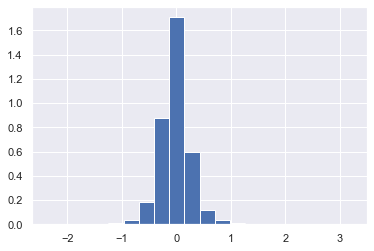

In [64]:
plt.hist(df_lean.values.flatten(),20,density=True)

(array([1.77677254e-03, 7.10709447e-04, 0.00000000e+00, 1.42141803e-03,
        4.97496462e-03, 2.41641102e-02, 7.59392756e-01, 4.24151205e+00,
        4.97496424e-02, 4.61960930e-03, 3.55354616e-04, 3.55354508e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.55354723e-04]),
 array([-1.4112344 , -1.2147471 , -1.0182599 , -0.8217726 , -0.62528527,
        -0.42879802, -0.23231074, -0.03582348,  0.1606638 ,  0.35715106,
         0.55363834,  0.7501256 ,  0.9466129 ,  1.1431001 ,  1.3395875 ,
         1.5360746 ,  1.732562  ,  1.9290493 ,  2.1255364 ,  2.3220239 ,
         2.518511  ], dtype=float32),
 <BarContainer object of 20 artists>)

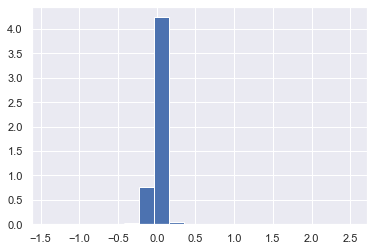

In [65]:
plt.hist(df_fatty.values.flatten(),20,density=True)

In [66]:
# lean_dx = pd.DataFrame(Input_lean.detach().cpu().numpy())
# lean_dx.columns = X_B.columns.values
# lean_dx.to_csv('dx_lean.csv')

In [67]:
# fatty_dx = pd.DataFrame(Input_fatty.detach().cpu().numpy())
# fatty_dx.columns = X_B.columns.values
# fatty_dx.to_csv('dx_fatty.csv')

### Validate with sklearn

In [68]:
# Xstar_lean = XB_lean + torch.tensor(df_lean.values).to(device)
# Xstar_fatty = XB_fatty + torch.tensor(df_fatty.values).to(device)
Xstar_lean = XB_lean + Input_lean
Xstar_fatty = XB_fatty + Input_fatty
X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
X = X.detach().cpu().numpy()

In [69]:
lean_ind = np.where(np.isin(X_B.index.values, lean_control_chips.index.values))[0]
fatty_ind = np.where(np.isin(X_B.index.values, fatty_control_chips.index.values))[0]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

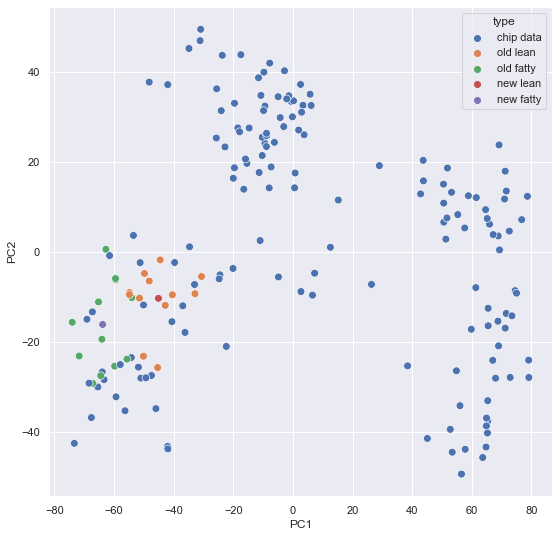

In [70]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
# transform your data into PCA space
Z_B = pca.transform(X)
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
pca_data["type"] = ['chip data' for i in range(XB.shape[0])] + ['new lean' for i in range(XB_lean.shape[0])] + ['new fatty' for i in range(XB_fatty.shape[0])]
pca_data.iloc[lean_ind,2] = 'old lean'
pca_data.iloc[fatty_ind,2] = 'old fatty'
plt.figure(figsize=(9, 9))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 ,hue='type')

In [71]:
loadings = pca.components_
print(loadings.shape)
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

(181, 14322)
The explained variance of the human data in the PC-space of liver chip is 46.87 %


### Perturb with dX all lean and fatty samples

In [72]:
XB_lean = X_B.loc[lean_control_chips.index.values,:]
XB_fatty = X_B.loc[fatty_control_chips.index.values,:]
XB_lean = torch.tensor(XB_lean.values).float().to(device)
XB_fatty = torch.tensor(XB_fatty.values).float().to(device)

In [73]:
Xstar_lean = XB_lean + torch.tensor(df_lean.values).to(device)
Xstar_fatty = XB_fatty + torch.tensor(df_fatty.values).to(device)

In [74]:
df_lean = np.concatenate([XB_lean.detach().cpu().numpy(),Xstar_lean.detach().cpu().numpy()],0)
df_lean = pd.DataFrame(df_lean)
df_lean.columns = X_B.columns.values
df_lean.index = ['control'+str(i) for i in range(XB_lean.shape[0])] + ['perturbed'+str(i) for i in range(XB_lean.shape[0])]
df_lean = df_lean.T
# df_lean.to_csv('pertubed_control_lean.csv')

In [75]:
df_fatty = np.concatenate([XB_fatty.detach().cpu().numpy(),Xstar_fatty.detach().cpu().numpy()],0)
df_fatty = pd.DataFrame(df_fatty)
df_fatty.columns = X_B.columns.values
df_fatty.index = ['control'+str(i) for i in range(XB_fatty.shape[0])] + ['perturbed'+str(i) for i in range(XB_fatty.shape[0])]
df_fatty = df_fatty.T
# df_fatty.to_csv('pertubed_control_fatty.csv')

In [76]:
X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
X = X.detach().cpu().numpy()

In [77]:
lean_ind = np.where(np.isin(X_B.index.values, lean_control_chips.index.values))[0]
fatty_ind = np.where(np.isin(X_B.index.values, fatty_control_chips.index.values))[0]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

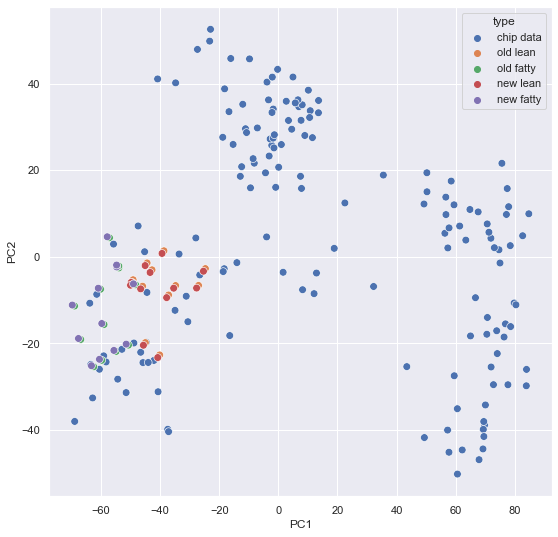

In [78]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
# transform your data into PCA space
Z_B = pca.transform(X)
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
pca_data["type"] = ['chip data' for i in range(XB.shape[0])] + ['new lean' for i in range(XB_lean.shape[0])] + ['new fatty' for i in range(XB_fatty.shape[0])]
pca_data.iloc[lean_ind,2] = 'old lean'
pca_data.iloc[fatty_ind,2] = 'old fatty'
plt.figure(figsize=(9, 9))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 ,hue='type')

In [79]:
loadings = pca.components_
print(loadings.shape)
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

(203, 14322)
The explained variance of the human data in the PC-space of liver chip is 46.98 %
